Using Gower Distance and DBSCAN to cluster customers of age 10-30

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gower
from sklearn.cluster import DBSCAN

In [2]:
table_nm = 'DLAB_INTERN_TR_IFO_TMP' 
names = ['iqr_dt','cus_no','act_no','mkt_gb','pdt_gb','iem_cd','iem_krl_anm','bnc_qty','tot_aet_amt'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE1030/{table_nm}_1030.csv' 
df_trd_1 = pd.read_csv(file_path)

table_nm = 'DLAB_INTERN_TR_IFO_TMP' 
names = ['iqr_dt','cus_no','act_no','mkt_gb','pdt_gb','iem_cd','iem_krl_anm','bnc_qty','tot_aet_amt'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE1030/{table_nm}2_1030.csv' 
df_trd_2 = pd.read_csv(file_path) 

table_nm = 'DLAB_HT_L1_CUS_IFO_TMP' 
names = ['cus_no','sex_dit_cd','cus_age','zip_ctp_cd', 'tco_cus_grd_cd', 'ivs_icn_cd'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE1030/{table_nm}_1030.csv' 
df_cus = pd.read_csv(file_path) 

table_nm = 'DLAB_HT_L1_ACT_IFO_TMP' 
names = ['act_no','cus_no','act_opn_ym'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE1030/{table_nm}_1030.csv' 
df_act = pd.read_csv(file_path) 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
'''
Index(['iqr_dt', 'cus_no', 'act_no', 'mkt_gb', 'pdt_gb', 'iem_cd', iem_krl_anm', 'bnc_qty', 'tot_aet_amt'])
날짜, 고객번호, 계죄번호, 국내/해외, 주식/ETF, 종목코드, 종목한글명, 수량, 총평가액
'''
df_trd = pd.merge(left=df_trd_1, right=df_trd_2[df_trd_2['iqr_dt'] > 20210701], how='outer')
df_trd = df_trd.drop('Unnamed: 0', axis=1)
df_trd.shape #(687001, 9)

(687001, 9)

In [4]:
'''
Index(['act_no', 'cus_no', 'act_opn_ym'])
계좌번호, 고객번호, 계좌개설년월
'''
df_act = df_act.drop('Unnamed: 0', axis=1)
df_act.shape #(844, 3)

(844, 3)

In [5]:
'''
Index(['cus_no', 'sex_dit_cd', 'cus_age', 'zip_ctp_cd', 'tco_cus_grd_cd', 'ivs_icn_cd'])
고객번호, 성별, 나이, 지역, 고객등급코드, 투자성향응답
'''
df_cus = df_cus.drop('Unnamed: 0', axis=1)
df_cus.shape #(500, 7)

(500, 6)

In [6]:
'''
choose 440 customers with trd data
remove noisy data (customers with DIREXION SEMICONDUCTOR BULL 3X ETF)
'''
df_cus_w = df_cus.copy()[(df_cus['cus_no'].isin(df_trd['cus_no'])) 
                         & ~(df_cus['cus_no'].isin(df_trd[(df_trd['iem_cd'] == "US25459W4583")]['cus_no']))]
df_cus_w.shape #(493, 6)

(493, 6)

In [7]:
'''
For each date from Jan. 1st to Dec. 31st,
sum up each customer's total asset amount 
'''
df_bal = df_trd.copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal = df_bal.reset_index()
df_bal.shape #(144907, 3)

(144907, 3)

In [8]:
'''
For each date from Jan. 1st to Dec. 31st,
sum up each customer's total [Korean Stock] asset amount
'''
df_bal_kor_stk = df_trd[(df_trd['mkt_gb'] == '국내') 
                        & (df_trd['pdt_gb'] == '주식')].copy()[['iqr_dt', 
                                                              'cus_no', 
                                                              'tot_aet_amt']].groupby(['iqr_dt', 
                                                                                       'cus_no']).sum()
df_bal_kor_stk = df_bal_kor_stk.reset_index()

In [9]:
'''
For each date from Jan. 1st to Dec. 31st,
sum up each customer's total [Foreign Stock] asset amount
'''
df_bal_ovs_stk = df_trd[(df_trd['mkt_gb'] == '해외') 
                        & (df_trd['pdt_gb'] == '주식')].copy()[['iqr_dt', 
                                                              'cus_no', 
                                                              'tot_aet_amt']].groupby(['iqr_dt', 
                                                                                       'cus_no']).sum()
df_bal_ovs_stk = df_bal_ovs_stk.reset_index()

In [10]:
'''
For each date from Jan. 1st to Dec. 31st,
sum up each customer's total [Korean ETF] asset amount
'''
df_bal_kor_etf = df_trd[(df_trd['mkt_gb'] == '국내') 
                        & (df_trd['pdt_gb'] == 'ETF')].copy()[['iqr_dt', 
                                                               'cus_no', 
                                                               'tot_aet_amt']].groupby(['iqr_dt', 
                                                                                        'cus_no']).sum()
df_bal_kor_etf = df_bal_kor_etf.reset_index()

In [11]:
'''
For each date from Jan. 1st to Dec. 31st,
sum up each customer's total [Foreign ETF] asset amount
'''
df_bal_ovs_etf = df_trd[(df_trd['mkt_gb'] == '해외') 
                        & (df_trd['pdt_gb'] == 'ETF')].copy()[['iqr_dt', 
                                                               'cus_no', 
                                                               'tot_aet_amt']].groupby(['iqr_dt', 
                                                                                        'cus_no']).sum()
df_bal_ovs_etf = df_bal_ovs_etf.reset_index()

In [12]:
'''
Combine all the previously calculated columns
'''
df_bal_tot = pd.merge(left=df_bal, 
                      right=df_bal_kor_stk[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kor_stk'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs_stk[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ovs_stk'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_kor_etf[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kor_etf'), 
                      
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs_etf[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ovs_etf'), 
                      how='left')
df_bal_tot.shape #(144907, 7)

(144907, 7)

In [13]:
'''
Fill NaN values in merged columns with 0
'''
df_bal_tot[['tot_aet_amt_kor_stk', 
            'tot_aet_amt_ovs_stk', 
            'tot_aet_amt_kor_etf', 
            'tot_aet_amt_ovs_etf']] = df_bal_tot[['tot_aet_amt_kor_stk', 
                                                  'tot_aet_amt_ovs_stk', 
                                                  'tot_aet_amt_kor_etf', 
                                                  'tot_aet_amt_ovs_etf']].fillna(0)

In [14]:
'''
Break the dataframe into a list (by each date)
Create sub-columns that depend on other columns
'''
df_bal_list = []
for i in df_bal_tot['iqr_dt'].unique():
    df = df_bal_tot[df_bal_tot['iqr_dt'] == i]
    df = pd.merge(left=df_cus_w, right=df, on='cus_no', suffixes=('',''))
    df['kor_etf_ratio'] = df['tot_aet_amt_kor_etf'] / (df['tot_aet_amt_kor_stk']+df['tot_aet_amt_kor_etf'])
    df['ovs_etf_ratio'] = df['tot_aet_amt_ovs_etf'] / (df['tot_aet_amt_ovs_stk']+df['tot_aet_amt_ovs_etf'])
    df['kor_ovs_amt_ratio'] = (df['tot_aet_amt_ovs_stk']+df['tot_aet_amt_ovs_etf'] )/ df['tot_aet_amt']
    df[['kor_etf_ratio', 'ovs_etf_ratio', 'kor_ovs_amt_ratio']] = df[['kor_etf_ratio', 'ovs_etf_ratio', 'kor_ovs_amt_ratio']].fillna(0)
    df_bal_list.append(df)

df = df_bal_list[364]
plt.scatter(df['cus_age'], df['kor_ovs_amt_ratio'])

In [15]:
'''
To cluster customers between 10 to 30 years old,
analyze their account info as of Dec. 31, 2021
'''
ten_thirty = df_bal_list[364].set_index(keys='cus_no')
ten_thirty = ten_thirty.drop(['ivs_icn_cd', 'iqr_dt', 'zip_ctp_cd', 'tco_cus_grd_cd'], axis=1) #drop unused columns
#ten_thirty = ten_thirty.drop(['tco_cus_grd_cd', 'tot_aet_amt', 'kor_etf_ratio', 'ovs_etf_ratio', 'kor_ovs_amt_ratio'], axis=1)
ten_thirty ['sex_dit_cd'] = ten_thirty['sex_dit_cd'].replace({1:'M', 2:'F'}) #categorize 

#Uncommenting the lines below will log the asset values 
ten_thirty[['tot_aet_amt_kor_stk',
            'tot_aet_amt_ovs_stk',
            'tot_aet_amt_kor_etf',
            'tot_aet_amt_ovs_etf']] = np.log10(ten_thirty[['tot_aet_amt_kor_stk',
                                                        'tot_aet_amt_ovs_stk',
                                                        'tot_aet_amt_kor_etf',
                                                        'tot_aet_amt_ovs_etf']],
                                             where = (ten_thirty[['tot_aet_amt_kor_stk',
                                                        'tot_aet_amt_ovs_stk',
                                                        'tot_aet_amt_kor_etf',
                                                        'tot_aet_amt_ovs_etf']] != 0))
ten_thirty.shape #(492, 10)

(492, 10)

In [16]:
'''
import 'gower' library
calculate the gower distance between each customer based on selected columns
save the distance info into a matrix

'''
dist_mat = pd.DataFrame(gower.gower_matrix(ten_thirty[['cus_age',
                                                      'tot_aet_amt_kor_stk',
                                                      'tot_aet_amt_ovs_stk',
                                                      'tot_aet_amt_kor_etf',
                                                      'tot_aet_amt_ovs_etf',
                                                      ]]), index=ten_thirty .index, columns=ten_thirty.index)
dist_mat.shape #(492, 492)

(492, 492)

In [17]:
'''
define DBSCAM model with parameters
because dist_mat is already calculated, use metric='precomputed'
fit the model
'''
dbscan_cluster = DBSCAN(eps=0.09, min_samples=20, metric='precomputed')
dbscan_cluster.fit(dist_mat)

DBSCAN(algorithm='auto', eps=0.09, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=20, n_jobs=None, p=None)

In [18]:
'''
group labels to count the number of data points in each cluster
'''
ten_thirty ['cluster'] = dbscan_cluster.labels_
ten_thirty_grp = ten_thirty.groupby('cluster').count()
ten_thirty_grp

,sex_dit_cd,cus_age,tot_aet_amt,tot_aet_amt_kor_stk,tot_aet_amt_ovs_stk,tot_aet_amt_kor_etf,tot_aet_amt_ovs_etf,kor_etf_ratio,ovs_etf_ratio,kor_ovs_amt_ratio
cluster,,,,,,,,,,
-1,53,53,53,53,53,53,53,53,53,53
0,25,25,25,25,25,25,25,25,25,25
1,326,326,326,326,326,326,326,326,326,326
2,66,66,66,66,66,66,66,66,66,66
3,22,22,22,22,22,22,22,22,22,22


In [19]:
'''
briefyly get the idea of how data points are being clustered
'''
ten_thirty.groupby('cluster').mean()

,cus_age,tot_aet_amt,tot_aet_amt_kor_stk,tot_aet_amt_ovs_stk,tot_aet_amt_kor_etf,tot_aet_amt_ovs_etf,kor_etf_ratio,ovs_etf_ratio,kor_ovs_amt_ratio
cluster,,,,,,,,,
-1,25.452830,2.085454e+07,4.142749,4.423772,3.068360,3.966831,0.294744,0.358709,5.072114e-01
0,26.320000,9.113784e+06,6.359636,0.000000,5.561387,0.000000,0.247156,0.000000,0.000000e+00
1,24.095092,7.298083e+06,6.337150,0.000000,0.000000,0.000000,0.000000,0.000000,8.209731e-10
2,25.651515,1.121828e+07,6.354720,5.615888,0.000000,0.000000,0.000000,0.000000,2.896850e-01
3,24.772727,5.113668e+06,0.000000,6.141363,0.000000,0.000000,0.000000,0.000000,1.000000e+00


In [20]:
'''
re-cluster the outliers with a higher eps value
'''
ten_thirty_x = ten_thirty.copy()[ten_thirty['cluster'] == -1]
dist_mat_x = pd.DataFrame(gower.gower_matrix(ten_thirty_x), index=ten_thirty_x .index, columns=ten_thirty_x.index)
dbscan_cluster_x = DBSCAN(eps=0.2, min_samples=15, metric='precomputed')
dbscan_cluster_x.fit(dist_mat_x)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=15, n_jobs=None, p=None)

In [21]:
ten_thirty_x['cluster'] = dbscan_cluster_x.labels_
ten_thirty_x_grp = ten_thirty_x.groupby('cluster').count()
ten_thirty_x_grp

,sex_dit_cd,cus_age,tot_aet_amt,tot_aet_amt_kor_stk,tot_aet_amt_ovs_stk,tot_aet_amt_kor_etf,tot_aet_amt_ovs_etf,kor_etf_ratio,ovs_etf_ratio,kor_ovs_amt_ratio
cluster,,,,,,,,,,
-1,24,24,24,24,24,24,24,24,24,24
0,29,29,29,29,29,29,29,29,29,29


In [22]:
ten_thirty_x.groupby('cluster').mean()

,cus_age,tot_aet_amt,tot_aet_amt_kor_stk,tot_aet_amt_ovs_stk,tot_aet_amt_kor_etf,tot_aet_amt_ovs_etf,kor_etf_ratio,ovs_etf_ratio,kor_ovs_amt_ratio
cluster,,,,,,,,,
-1,25.166667,1.722288e+07,3.891026,3.394151,5.846509,2.331592,0.639483,0.253099,0.305903
0,25.689655,2.386004e+07,4.351071,5.275873,0.769203,5.320132,0.009443,0.446110,0.673811


In [23]:
'''
For each cluster, print out the top five popular stocks on Dec. 31, 2021
'''

def top_five(i):
    return df_trd[(df_trd['iqr_dt'] == 20211231) 
           & (df_trd['cus_no'].isin(ten_thirty[ten_thirty['cluster'] == i-1].reset_index()['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', 
                                                                                                                                                 ascending=False)['cus_no'].head() / ten_thirty_grp['cus_age'][i-1]

In [24]:
'''
outliers of outlier group
'''
i = 0
df_trd[(df_trd['iqr_dt'] == 20211231) 
           & (df_trd['cus_no'].isin(ten_thirty_x[ten_thirty_x['cluster'] == i-1].reset_index()['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', 
                                                                                                                                                 ascending=False)['cus_no'].head() / ten_thirty_x_grp['cus_age'][i-1]

iem_krl_anm
삼성전자                         0.291667
TIGER KRX2차전지K-뉴딜            0.208333
TIGER 미국S&P500               0.208333
TIGER 미국필라델피아반도체나스닥          0.208333
INVSC QQQ TRUST SRS 1 ETF    0.166667
Name: cus_no, dtype: float64

In [25]:
'''
cluster 0 of outlier group
'''
i = 1
df_trd[(df_trd['iqr_dt'] == 20211231) 
           & (df_trd['cus_no'].isin(ten_thirty_x[ten_thirty_x['cluster'] == i-1].reset_index()['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', 
                                                                                                                                                 ascending=False)['cus_no'].head() / ten_thirty_x_grp['cus_age'][i-1]

iem_krl_anm
삼성전자    0.586207
애플      0.310345
스타벅스    0.206897
현대차     0.206897
카카오     0.206897
Name: cus_no, dtype: float64

In [26]:
'''
for each cluster, print out the top 5 popular stocks
'''
for i in range(len(ten_thirty_grp)):
    print('Group:' + str(i-1))
    display(top_five(i))

Group:-1


iem_krl_anm
삼성전자                         0.452830
애플                           0.226415
INVSC QQQ TRUST SRS 1 ETF    0.150943
삼성전자우                        0.132075
카카오                          0.132075
Name: cus_no, dtype: float64

Group:0


iem_krl_anm
삼성전자                 0.44
삼성전자우                0.44
카카오                  0.24
SK하이닉스               0.20
TIGER KRX2차전지K-뉴딜    0.20
Name: cus_no, dtype: float64

Group:1


iem_krl_anm
삼성전자      0.493865
카카오       0.180982
삼성전자우     0.110429
대한항공      0.104294
SK하이닉스    0.058282
Name: cus_no, dtype: float64

Group:2


iem_krl_anm
삼성전자    0.560606
카카오     0.212121
애플      0.196970
현대차     0.181818
대한항공    0.090909
Name: cus_no, dtype: float64

Group:3


iem_krl_anm
애플                0.272727
AMD               0.227273
Meta Platforms    0.136364
보잉                0.090909
엔비디아              0.090909
Name: cus_no, dtype: float64

Below is to show how hierarchical DBSCAN clustering works 

In [27]:
ten_thirty_db = ten_thirty.copy()[['tot_aet_amt',
                                                          'kor_ovs_amt_ratio'
                                                      ]]
dist_mat_db = pd.DataFrame(gower.gower_matrix(ten_thirty_db), index=ten_thirty_db.index, columns=ten_thirty_db.index)

In [28]:
dbscan_cluster_db = DBSCAN(eps=0.09, min_samples=20, metric='precomputed')
dbscan_cluster_db.fit(dist_mat_db)

ten_thirty_db['cluster'] = dbscan_cluster_db.labels_
ten_thirty_grp_db = ten_thirty_db.groupby('cluster').count()
ten_thirty_grp_db

,tot_aet_amt,kor_ovs_amt_ratio
cluster,,
-1,8,8
0,423,423
1,61,61


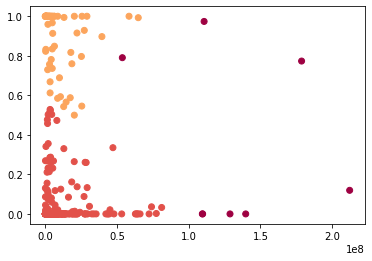

In [29]:
cmap = plt.cm.get_cmap("Spectral")
colors = cmap((ten_thirty_db['cluster']+1) / 7)
plt.scatter(ten_thirty_db['tot_aet_amt'], ten_thirty_db['kor_ovs_amt_ratio'], c=colors)
plt.show()

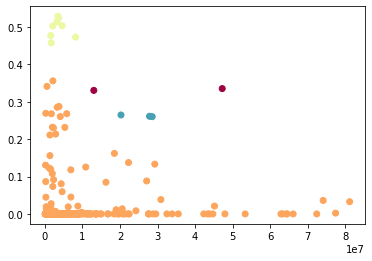

In [30]:
ten_thirty_db_0 = ten_thirty_db[ten_thirty_db['cluster'] == 0].copy()
dist_mat_db_0 = pd.DataFrame(gower.gower_matrix(ten_thirty_db_0), 
                             index=ten_thirty_db_0.index, 
                             columns=ten_thirty_db_0.index)
dbscan_cluster_db_0 = DBSCAN(eps=0.05, min_samples=2, metric='precomputed')
dbscan_cluster_db_0.fit(dist_mat_db_0)

ten_thirty_db_0['cluster'] = dbscan_cluster_db_0.labels_
ten_thirty_grp_db_0 = ten_thirty_db_0.groupby('cluster').count()
cmap = plt.cm.get_cmap("Spectral")
colors = cmap((ten_thirty_db_0['cluster']+1) / 3.5)
plt.scatter(ten_thirty_db_0['tot_aet_amt'], ten_thirty_db_0['kor_ovs_amt_ratio'], c=colors)
plt.show()

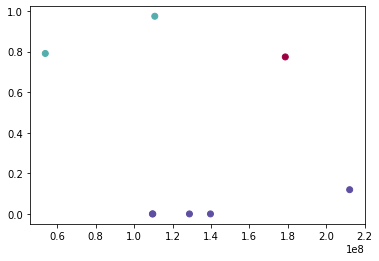

In [31]:
ten_thirty_db_0 = ten_thirty_db[ten_thirty_db['cluster'] == -1].copy()
dist_mat_db_0 = pd.DataFrame(gower.gower_matrix(ten_thirty_db_0), 
                             index=ten_thirty_db_0.index, 
                             columns=ten_thirty_db_0.index)
dbscan_cluster_db_0 = DBSCAN(eps=0.2, min_samples=2, metric='precomputed')
dbscan_cluster_db_0.fit(dist_mat_db_0)

ten_thirty_db_0['cluster'] = dbscan_cluster_db_0.labels_
ten_thirty_grp_db_0 = ten_thirty_db_0.groupby('cluster').count()
cmap = plt.cm.get_cmap("Spectral")
colors = cmap((ten_thirty_db_0['cluster']+1) / 1.2)
plt.scatter(ten_thirty_db_0['tot_aet_amt'], ten_thirty_db_0['kor_ovs_amt_ratio'], c=colors)
plt.show()